# Initial Imports and Constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from lightkurve import search_targetpixelfile
import pandas as pd
import os
import batman
from scipy.stats import norm
import matplotlib
import os

In [2]:
### Define data directory
working_dir = os.getcwd()
data_dir = os.path.join(working_dir, "data")
print(f"Data directory: {data_dir}")

Data directory: /Users/pentrican10/Projects/tess-resonant-systems/data


In [3]:
### switch to mask out transits
mask_transits = True
### set range for search: [#hours] * [days per hour]
ttv_hour = 2* 0.0416667 # 1 hour to days

In [4]:
### function to convert times from TESS to Petigura offset
TESS_offset = 2457000
petigura_offset = 2454833
def convert_time_t2p(times):
    ### TESS offset 
    BTJD = times + TESS_offset
    new_time = BTJD - petigura_offset
    return new_time

# Get data

In [5]:
TOI_id = 'TOI 270'
search_result = lk.search_lightcurve(TOI_id, author='SPOC')
print(search_result)
# lc_collection = search_result.download_all()
# lc = lc_collection
# lc[0].download()
# lc[1].download()
# lc[2].download()
# lc[3].download()


# lc_collection = lc[0].download()
# lc_collection.append(lc[1].download())
# lc_collection.append(lc[3].download())

SearchResult containing 7 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 03 2018   SPOC     120   259377017      0.0
  1 TESS Sector 04 2018   SPOC     120   259377017      0.0
  2 TESS Sector 05 2018   SPOC     120   259377017      0.0
  3 TESS Sector 30 2020   SPOC      20   259377017      0.0
  4 TESS Sector 32 2020   SPOC      20   259377017      0.0
  5 TESS Sector 30 2020   SPOC     120   259377017      0.0
  6 TESS Sector 32 2020   SPOC     120   259377017      0.0


In [6]:
lc_collection = search_result.download_all()
# lc_collection.plot()
# plt.show()
print(lc_collection)

LightCurveCollection of 7 objects:
    0: <TessLightCurve LABEL="TIC 259377017" SECTOR=3 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 259377017" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 259377017" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 259377017" SECTOR=30 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    4: <TessLightCurve LABEL="TIC 259377017" SECTOR=32 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    5: <TessLightCurve LABEL="TIC 259377017" SECTOR=30 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    6: <TessLightCurve LABEL="TIC 259377017" SECTOR=32 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>


In [7]:
clean_lcs = [lc[lc.quality == 0] for lc in lc_collection]


In [8]:
# Normalize, flatten, and remove outliers
processed_lcs = [
    lc.normalize().flatten(window_length=401).remove_outliers(sigma=5)
    for lc in clean_lcs
]

In [9]:
# Stitch into one combined light curve
combined_lc = processed_lcs[0]
for lc in processed_lcs[1:]:
    combined_lc = combined_lc.append(lc)



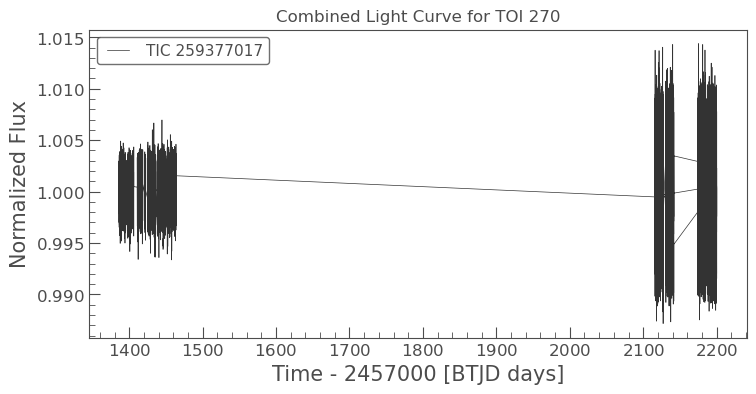

In [10]:
combined_lc.plot()
plt.title(f"Combined Light Curve for {TOI_id}")
plt.show()

In [11]:
# Extract useful data arrays
time = combined_lc.time.value
flux = combined_lc.flux.value
flux_err = combined_lc.flux_err.value
print(time)
print(flux)

[1385.94982733 1385.95121625 1385.95260517 ... 2200.148052   2200.14944086
 2200.15082971]
[1.00113641 0.99830573 1.00104735 ... 1.00229433 1.00021224 1.00036765]


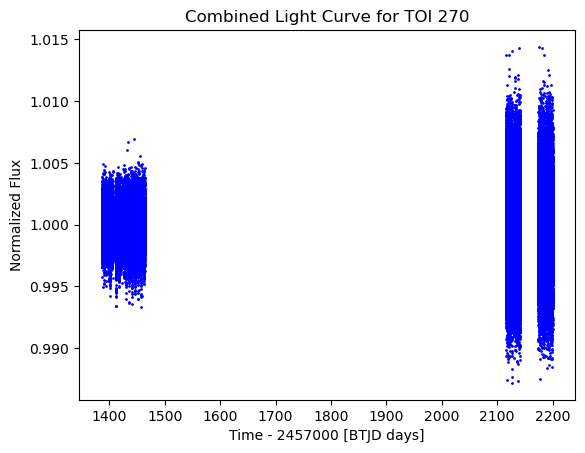

In [12]:
plt.scatter(time, flux, s=1, c='b')
plt.title(f'Combined Light Curve for {TOI_id}')
plt.xlabel('Time - 2457000 [BTJD days]')
plt.ylabel('Normalized Flux')
plt.show()

# BLS Runs

## BLS 1

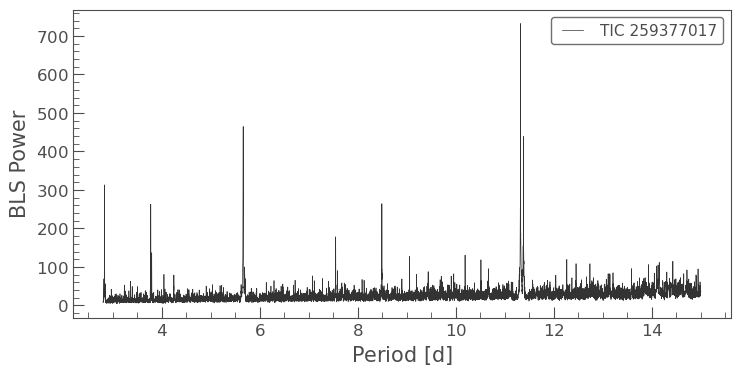

In [13]:
bls_1 = combined_lc.to_periodogram(method='bls', period=np.linspace(2.8, 15, 10000), frequency_factor=500)
bls_1.plot()
plt.show()


In [14]:
planet_1_period = bls_1.period_at_max_power
planet_1_dur = bls_1.duration_at_max_power
planet_1_t0 = bls_1.transit_time_at_max_power

print(f"Best candidate period: {planet_1_period.value:.5f} days")
print(f"Best candidate t0: {planet_1_t0.value:.5f} days")

Best candidate period: 11.32133 days
Best candidate t0: 1395.15483 days


In [15]:
import numpy as np
from scipy.signal import find_peaks

# 1. Access full power array
powers = bls_1.power.value
periods = bls_1.period.value
durations = bls_1.duration.value
t0s = bls_1.transit_time.value

# 2. Find all peaks in the BLS power spectrum
peaks, _ = find_peaks(powers)

# 3. Sort peaks by power (descending)
sorted_peaks = peaks[np.argsort(powers[peaks])[::-1]]

# 4. Get top 3 signal indices
top_indices = sorted_peaks[:7]

# 5. Extract their periods, durations, and t0s
top_periods = periods[top_indices]
top_durations = durations[top_indices]
top_t0s = t0s[top_indices]
top_powers = powers[top_indices]

# 6. Print results
for i in range(7):
    print(f"Signal {i+1}:")
    print(f"  Period:   {top_periods[i]:.5f} days")
    print(f"  T0:       {top_t0s[i]:.5f}")
    print(f"  Duration: {top_durations[i]:.5f} days")
    print(f"  Power:    {top_powers[i]:.5f}")
    print("-" * 30)


Signal 1:
  Period:   11.32133 days
  T0:       1395.15483
  Duration: 0.05000 days
  Power:    732.01665
------------------------------
Signal 2:
  Period:   5.66119 days
  T0:       1389.45483
  Duration: 0.15000 days
  Power:    464.60590
------------------------------
Signal 3:
  Period:   11.37990 days
  T0:       1389.66983
  Duration: 0.05000 days
  Power:    438.71814
------------------------------
Signal 4:
  Period:   2.83050 days
  T0:       1386.63483
  Duration: 0.10000 days
  Power:    312.97616
------------------------------
Signal 5:
  Period:   8.49065 days
  T0:       1386.67483
  Duration: 0.05000 days
  Power:    264.21993
------------------------------
Signal 6:
  Period:   3.77366 days
  T0:       1387.62483
  Duration: 0.05000 days
  Power:    262.79142
------------------------------
Signal 7:
  Period:   11.31645 days
  T0:       1389.51483
  Duration: 0.05000 days
  Power:    252.41353
------------------------------


In [16]:
# Create a cadence mask using the BLS parameters
planet_1_mask = bls_1.get_transit_mask(period=planet_1_period,
                                     transit_time=planet_1_t0,
                                     duration=planet_1_dur*1.5)

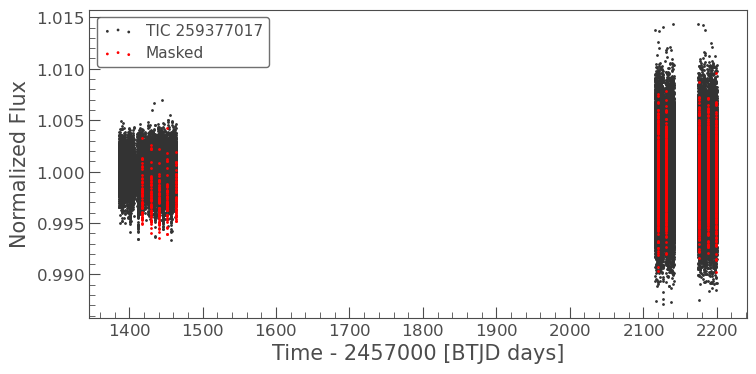

In [17]:
masked_lc_1 = combined_lc[~planet_1_mask]
ax = masked_lc_1.scatter();
combined_lc[planet_1_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [18]:
# Create a BLS model using the BLS parameters
planet_1_model = bls_1.get_transit_model(period=planet_1_period,
                                       transit_time=planet_1_t0,
                                       duration=planet_1_dur)


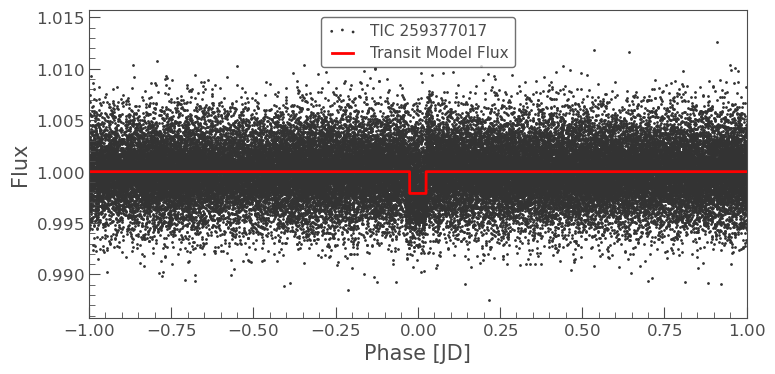

In [19]:
ax = combined_lc.fold(planet_1_period, planet_1_t0).scatter()
planet_1_model.fold(planet_1_period, planet_1_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## BLS 2

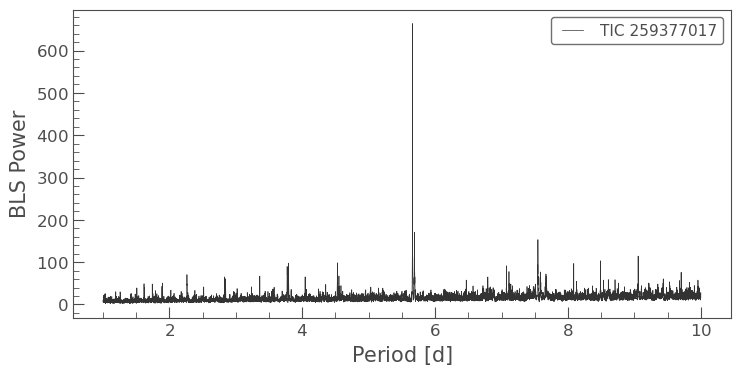

In [20]:
period = np.linspace(1, 10, 10000)
bls_2 = masked_lc_1.to_periodogram('bls', period=period, frequency_factor=500)
bls_2.plot()
plt.show()

In [21]:
planet_2_period = bls_2.period_at_max_power
planet_2_t0 = bls_2.transit_time_at_max_power
planet_2_dur = bls_2.duration_at_max_power

print(f"Best candidate period 2: {planet_2_period.value:.5f} days")
print(f"Best candidate t0 2: {planet_2_t0.value:.5f} days")

Best candidate period 2: 5.66067 days
Best candidate t0 2: 1389.49483 days


In [22]:
# ax = masked_lc_1.fold(planet_2_period, planet_2_t0).scatter()
# masked_lc_1.fold(planet_2_period, planet_2_t0).bin(.1).plot(ax=ax, c='r', lw=2,
#                                                           label='Binned Flux')
# ax.set_xlim(-5, 5)
# plt.show()

In [23]:
planet_2_mask = bls_2.get_transit_mask(period=planet_2_period,
                                     transit_time=planet_2_t0,
                                     duration=planet_2_dur*1.5)

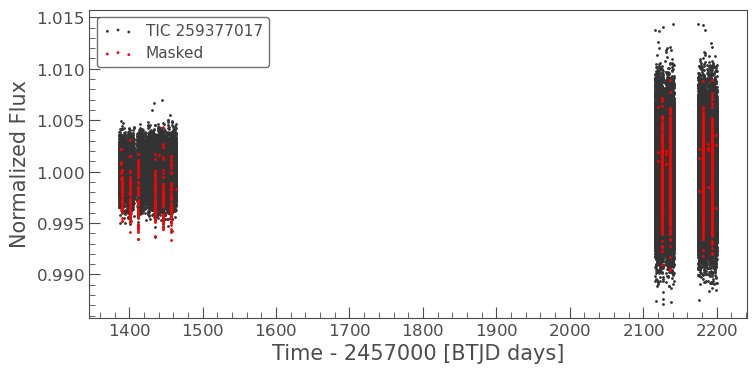

In [24]:
masked_lc_2 = masked_lc_1[~planet_2_mask]
ax = masked_lc_2.scatter();
masked_lc_1[planet_2_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [25]:
planet_2_model = bls_2.get_transit_model(period=planet_2_period,
                                       transit_time=planet_2_t0,
                                       duration=planet_2_dur)

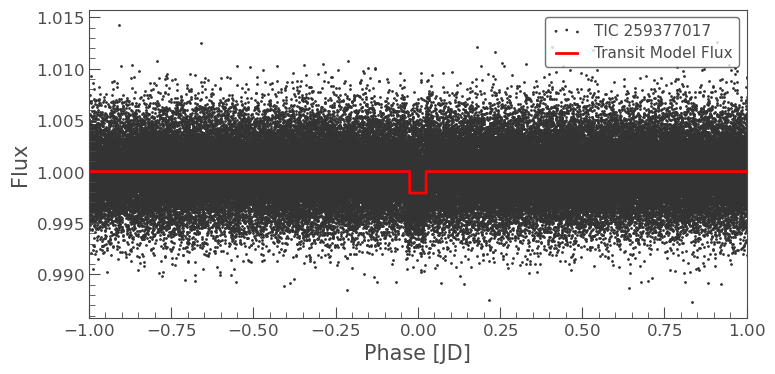

In [26]:
ax = combined_lc.fold(planet_2_period, planet_2_t0).scatter()
planet_2_model.fold(planet_2_period, planet_2_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1)
plt.show()

## BLS 3

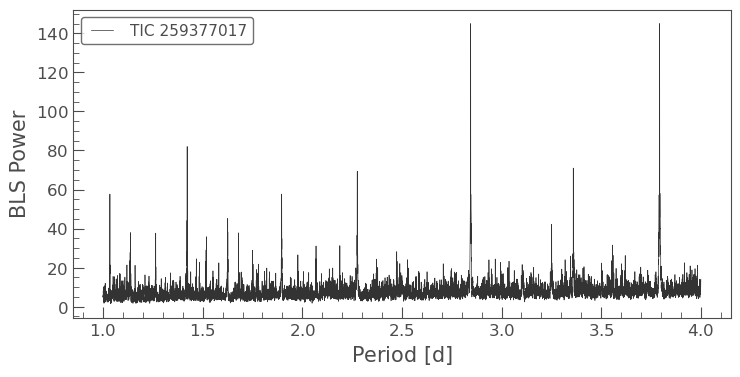

In [27]:
### start period search at 4days to try to find planet e before d
period = np.linspace(1, 4, 10000)
bls_3 = masked_lc_2.to_periodogram('bls', period=period, frequency_factor=500)
bls_3.plot()
plt.show()

In [28]:
planet_3_period = bls_3.period_at_max_power
planet_3_t0 = bls_3.transit_time_at_max_power
planet_3_dur = bls_3.duration_at_max_power

print(f"Best candidate period 3: {planet_3_period.value:.5f} days")
print(f"Best candidate t0 3: {planet_3_t0.value:.5f} days")

Best candidate period 3: 3.79328 days
Best candidate t0 3: 1389.66983 days


In [29]:
planet_3_mask = bls_3.get_transit_mask(period=planet_3_period,
                                     transit_time=planet_3_t0,
                                     duration=planet_3_dur*1.5)


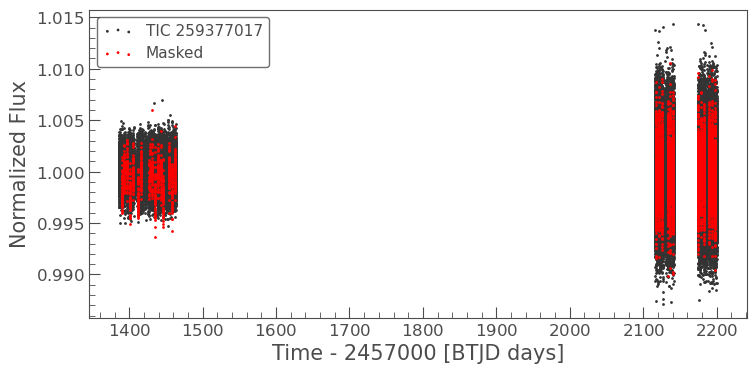

In [30]:
masked_lc_3 = masked_lc_2[~planet_3_mask]
ax = masked_lc_3.scatter();
masked_lc_2[planet_3_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [31]:
planet_3_model = bls_3.get_transit_model(period=planet_3_period,
                                       transit_time=planet_3_t0,
                                       duration=planet_3_dur)

In [32]:
period = np.linspace(1, 15, 10000)
bls_5 = masked_lc_4.to_periodogram('bls', period=period, frequency_factor=500)
bls_5.plot()
plt.show()

NameError: name 'masked_lc_4' is not defined

In [ ]:
planet_5_period = bls_5.period_at_max_power
planet_5_t0 = bls_5.transit_time_at_max_power
planet_5_dur = bls_5.duration_at_max_power

print(f"Best candidate period 5: {planet_5_period.value:.5f} days")
print(f"Best candidate t0 5: {planet_5_t0.value:.5f} days")

In [ ]:
planet_5_mask = bls_5.get_transit_mask(period=planet_5_period,
                                     transit_time=planet_5_t0,
                                     duration=planet_5_dur*1.5)


In [ ]:
masked_lc_5 = masked_lc_4[~planet_5_mask]
ax = masked_lc_5.scatter();
masked_lc_4[planet_5_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [ ]:
planet_5_model = bls_5.get_transit_model(period=planet_5_period,
                                       transit_time=planet_5_t0,
                                       duration=planet_5_dur)

In [ ]:
period = np.linspace(1, 15, 10000)
bls_6 = masked_lc_5.to_periodogram('bls', period=period, frequency_factor=500)
bls_6.plot()
plt.show()

In [ ]:
planet_6_period = bls_6.period_at_max_power
planet_6_t0 = bls_6.transit_time_at_max_power
planet_6_dur = bls_6.duration_at_max_power

print(f"Best candidate period 6: {planet_6_period.value:.5f} days")
print(f"Best candidate t0 6: {planet_6_t0.value:.5f} days")

In [ ]:
planet_6_mask = bls_6.get_transit_mask(period=planet_6_period,
                                     transit_time=planet_6_t0,
                                     duration=planet_6_dur*1.5)


In [ ]:
masked_lc_6 = masked_lc_5[~planet_6_mask]
ax = masked_lc_6.scatter();
masked_lc_5[planet_6_mask].scatter(ax=ax, c='r', label='Masked')
# plt.xlim(2144, 2145)
plt.show()

In [ ]:
planet_6_model = bls_6.get_transit_model(period=planet_6_period,
                                       transit_time=planet_6_t0,
                                       duration=planet_6_dur)

## Transit models

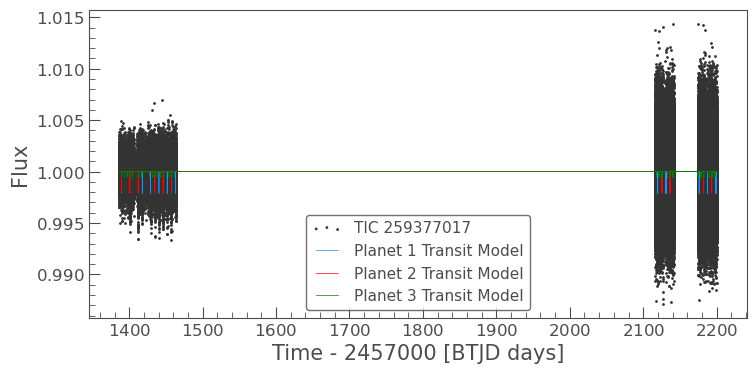

In [33]:
ax = combined_lc.scatter();
planet_1_model.plot(ax=ax, c='dodgerblue', label='Planet 1 Transit Model');
planet_2_model.plot(ax=ax, c='r', label='Planet 2 Transit Model');
planet_3_model.plot(ax=ax, c='g', label='Planet 3 Transit Model');
# planet_4_model.plot(ax=ax, c='purple', label='Planet 4 Transit Model');
# planet_5_model.plot(ax=ax, c='orange', label='Planet 5? Transit Model');
# planet_6_model.plot(ax=ax, c='pink', label='Planet 6 Transit Model');

# plt.xlim(1340,1345)
# plt.ylim(0.998,1.002)
plt.show()

## Finding transit guess times based on models 

In [34]:
from scipy.signal import find_peaks

# Find all local minima (i.e., transit dips)
peaks_1, _ = find_peaks(-planet_1_model.flux.value, prominence=1e-5)
transit_times_1 = planet_1_model.time.value[peaks_1]
fluxes_1 = planet_1_model.flux.value[peaks_1]

print("Planet 1 transit dip times and depths:")
# for t, f in zip(transit_times_1, fluxes_1):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_1)

Planet 1 transit dip times and depths:
[1417.79745613 1429.11830898 1440.43909012 1451.76119142 1463.08184762
 2119.72005632 2131.04129763 2176.32726384 2187.648406   2198.96879719
 2119.71901463 2131.04141338 2176.32622218 2187.64690138 2198.96891293]


In [35]:
# Find all local minima (i.e., transit dips)
peaks_2, _ = find_peaks(-planet_2_model.flux.value, prominence=1e-5)
transit_times_2 = planet_2_model.time.value[peaks_2]
fluxes_2 = planet_2_model.flux.value[peaks_2]

print("Planet 2 transit dip times and depths:")
# for t, f in zip(transit_times_2, fluxes_2):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_2)

Planet 2 transit dip times and depths:
[1389.49434202 1400.81535442 1412.1363033  1434.77940289 1446.10015516
 1457.42222846 2125.38126085 2136.70294479 2181.98807497 2193.30896337
 2125.38021917 2136.70398647 2181.98726479 2193.30931059]


In [36]:
# Find all local minima (i.e., transit dips)
peaks_3, _ = find_peaks(-planet_3_model.flux.value, prominence=1e-6)
transit_times_3 = planet_3_model.time.value[peaks_3]
fluxes_3 = planet_3_model.flux.value[peaks_3]

print("Planet 3 transit dip times and depths:")
# for t, f in zip(transit_times_3, fluxes_3):
#     print(f"Time: {t:.5f}, Flux: {f:.6f}")
print(transit_times_3)
print(len(transit_times_3))

Planet 3 transit dip times and depths:
[1389.66934523 1393.46246358 1397.25557516 1401.04869112 1404.84179467
 1412.42936174 1416.22244751 1427.60858618 1431.39469473 1435.18912254
 1438.9835416  1442.77518582 1446.56820556 1454.15421909 1457.94860904
 1461.74159732 2117.97951257 2121.77263951 2125.56552273 2133.15267178
 2136.94600276 2140.73908937 2174.87843348 2178.67168349 2182.46515124
 2190.05161293 2193.84460124 2197.63850346 2117.97870237 2121.77182932
 2125.56494402 2133.15255604 2136.94565553 2140.73874214 2174.8776233
 2178.67064183 2182.46503551 2190.05103423 2193.84402255 2197.63699886]
40


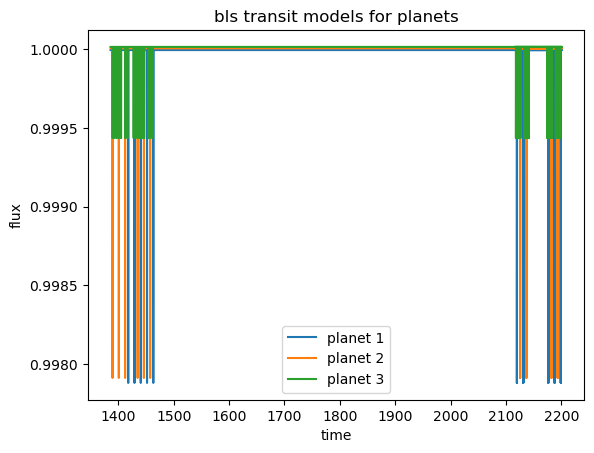

In [37]:
plt.plot(planet_1_model.time.value, planet_1_model.flux.value, label='planet 1')
plt.plot(planet_2_model.time.value, planet_2_model.flux.value, label='planet 2')
plt.plot(planet_3_model.time.value, planet_3_model.flux.value, label='planet 3')
# plt.plot(planet_4_model.time.value, planet_4_model.flux.value, label='planet 4')
# plt.plot(planet_5_model.time.value, planet_5_model.flux.value, label='planet 5?')
# plt.plot(planet_6_model.time.value, planet_6_model.flux.value, label='planet 6?')

# plt.xlim(1335,1345)
# plt.xlim(1330,1350)
# plt.xlim(2100,2200)
# plt.xlim(1377,1380)
plt.title('bls transit models for planets')
plt.xlabel('time')
plt.ylabel('flux')
plt.legend()
plt.show()

# Fit Transit Times

In [38]:
from scipy.optimize import minimize
from scipy.optimize import root_scalar
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

## Definitions

In [39]:
def omc(obs_time, t_num, p, tc):
    calc_time = tc + (t_num* p)
    omc = obs_time - calc_time
    return omc#*24 #days to hours

### Find the intersection points
def intersection_func(t,tc1,chi_sq, err_threshold): 
    return np.interp(t, tc1, chi_sq) - err_threshold

In [40]:

def plot_chi_sq(time, flux, flux_err, tc, tc_guess, per, rp, b, T14, u1, u2):
    '''
    args:
        time: array of times from lightcurve
        flux: array of fluxes from lightcurve
        flux_err: array of flux errors from lightcurve
        tc: range of values around the guess time
        tc_guess: guess transit time
        per: period of planet
        rp: radius ratio (planet/star)
        b: impact parameter
        T14: transit duration
        u1, u2: limb darkening coefficients 
    '''
    ### plot X^2 vs tc for each guess
    for j in range(len(tc)):
        tc1 = tc[j]
        chi_sq = np.zeros(len(tc1))
        chi_sq_lc = np.zeros(len(tc1))
        for i in range(len(tc1)):
            t0_1 = 	tc1[i]
            theta_initial = [t0_1, per, rp, b, T14, u1, u2]
            
            ### initialize params
            params = batman.TransitParams()
            # params.t0, params.per, params.rp,params.b, params.T14, q1, q2 = theta_initial
            # params.u = [2*np.sqrt(q1)*q2, np.sqrt(q1)*(1-2*q2)]  # Limb darkening coefficients
            params.t0, params.per, params.rp,params.b, params.T14, u1, u2 = theta_initial
            params.u = [u1, u2] 
            params.limb_dark = 'quadratic'
            
            ### mask data - extract relevant photometry
            start = tc_guess[j] - ttv_hour
            end = tc_guess[j] + ttv_hour
            mask = (time > (start)) & (time < (end))
            
            transit_model = batman.TransitModel(params, time[mask])
                
            # Generate model light curve
            model_flux = transit_model.light_curve(params)
            
            # Calculate chi-squared value
            sigma2 = flux_err[mask] 
            chi_squared = np.sum(((flux[mask] - model_flux) / sigma2)**2)
            chi_sq[i] = (chi_squared)
    
        ### masked
        min_chi_time = tc1[np.argmin(chi_sq)]
        min_chi = chi_sq.min()
    
        tc_chi[j] = min_chi_time
        # idx = transit_num[j]
        ttv[j] = min_chi_time - tc_guess[j]
    
        chi_mask = (chi_sq <= min_chi + 3)
        fit_mask = (chi_sq <= min_chi + 1)
    
        ### fit parabola to the chisq
        p_chi_sq = np.polyfit(tc1[fit_mask], chi_sq[fit_mask], 2)  
    
        ### Extract the coefficients   y = ax^2 + bx + c
        a_chi_sq, b_chi_sq, c_chi_sq = p_chi_sq
        
        ### Find the minimum of the parabola xmin = -b/2a from taking derivative=0
        tc_best_fit = -b_chi_sq / (2 * a_chi_sq)
        
        ### Calculate the minimum chi-squared value
        chi_sq_min = a_chi_sq * tc_best_fit**2 + b_chi_sq * tc_best_fit + c_chi_sq
        tc_chi_parabola[j] = tc_best_fit
    
        ### Calculate the parabola best fit 
        p_1 = a_chi_sq*tc1**2 + b_chi_sq*tc1 + c_chi_sq
    
        ### calculate ttv from parabola fit 
        ttv_p[j] = tc_best_fit - tc_guess[j]
    
        ### delta chisq = 1 gives errors
        err_threshold = min_chi + 1 # using chisq discrete minimum
        err_threshold_p = chi_sq_min + 1 # using minimum of parabola
      
        # # Find the intersection using root_scalar
        # intersections = []
        # for k in range(len(tc1) - 1):
        #     if (chi_sq[k] - err_threshold) * (chi_sq[k + 1] - err_threshold) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections.append((sol.root - min_chi_time))
        # errors.append(intersections)
    
        # intersections_p = []
        # for k in range(len(tc1) - 1):
        #     if (p_1[k] - err_threshold_p) * (p_1[k + 1] - err_threshold_p) < 0:
        #         sol = root_scalar(intersection_func, bracket=[tc1[k], tc1[k + 1]], args=(tc1, chi_sq, err_threshold))
        #         if sol.converged:
        #             intersections_p.append((sol.root - tc_best_fit))
        # errors_p.append(intersections_p)
    
        # plt.plot(tc1[chi_mask], chi_sq[chi_mask],label='chisq')
        # plt.plot(tc1[chi_mask], p_1[chi_mask],label='chisq parabola', color='orange')
        # plt.axvline(x=tc_guess[j], color='r', linestyle='--', label='Bls Guess')
        # plt.axvline(x=min_chi_time, linestyle='--', label='Chisq min')
        # plt.axvline(x=tc1[np.argmin(p_1)], color='orange', linestyle='--', label='Chisq min parabola')
    
        # # for inter in intersections:
        # #     plt.axvline(x=inter, color='blue', linestyle='--')
        # plt.axhline(y=err_threshold, color='green', linestyle='--', label='Error Threshold')
        # plt.title(f'Transit {j+1}: Planet b')
        # plt.xlabel('tc')
        # plt.ylabel('X^2')
        # plt.legend()
        # plt.show()

    return tc_chi, ttv

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import batman

def plot_transits(transit_times, per, rp, b, T14, u1, u2):
    cols = 3
    rows = int(np.ceil(len(transit_times) / cols))
    
    fig = plt.figure(figsize=(14, rows * 2.8))
    outer = gridspec.GridSpec(rows, cols, figure=fig, wspace=0.3, hspace=0.5)
    
    for i, t0 in enumerate(transit_times):
        row = i // cols
        col = i % cols
        inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[row, col],
                                                 height_ratios=[3, 1], hspace=0.0)  # Panels touch
    
        t_min = t0 - buffer
        t_max = t0 + buffer
        mask = (time >= t_min) & (time <= t_max)
        time_rel = time[mask] - t0  # Time relative to Tc
    
        # Transit model setup
        theta_initial = [t0, per, rp, b, T14, u1, u2]
        params = batman.TransitParams()
        params.t0, params.per, params.rp, params.b, params.T14, u1, u2 = theta_initial
        params.u = [u1, u2]
        params.limb_dark = 'quadratic'
    
        m = batman.TransitModel(params, time[mask])
        model_flux = m.light_curve(params)
        residuals = flux[mask] - model_flux
    
        # Top panel: model + data
        ax1 = fig.add_subplot(inner[0])
        ax1.scatter(time_rel, flux[mask], s=5, label='Data')
        ax1.plot(time_rel, model_flux, color='red', label='Model')
        ax1.axvline(0, color='green', linestyle='--', label='Tc')
        ax1.set_xlim(-buffer, buffer)
        ax1.set_title(f'Tc = {round(t0, 3)} (BJD-{TESS_offset})')
        ax1.grid(True)
        ax1.tick_params(labelbottom=False)
    
        # Bottom panel: residuals
        ax2 = fig.add_subplot(inner[1], sharex=ax1)
        ax2.scatter(time_rel, residuals, s=5)
        ax2.axhline(0, color='red', linestyle='--', linewidth=1)
        ax2.set_xlim(-buffer, buffer)
        ax2.set_xlabel("Time from Tc [days]")
        ax2.grid(True)
    
        # Y-axis labels for first column only
        if col == 0:
            ax1.set_ylabel("Flux")
            ax2.set_ylabel("Residuals")
        else:
            ax1.set_ylabel("")
            ax1.tick_params(labelleft=False)
            ax2.set_ylabel("")
            ax2.tick_params(labelleft=False)
    
        # Custom ticks
        ticks = np.round(np.linspace(-buffer, buffer, 4), 2)
        ax2.set_xticks(ticks)
    
    plt.show()


In [42]:
### stellar params
q1 = 0.17
q2 = 0.71

u1 = 2 * np.sqrt(q1) * q2
u2 = np.sqrt(q1) * (1 - 2 * q2)
print(u1)
print(u2)

0.5854809988377078
-0.17317043627594172


## Planet 1

In [43]:
### Planet params (from exoplanet archive Van Eylen et al 2021)
# planet b
per_1=  11.379573
rp_1= 0.05163
b_1= 0.19
T14_1= 2.148 * 0.0416667  # convert to days from hours (from Gunther et al 2019)


In [44]:
tc_guess_1 = transit_times_1
### get tc ranges for fit
tc_1 = []
for i in range(len(tc_guess_1)):
    start = tc_guess_1[i] - ttv_hour
    end = tc_guess_1[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_1.append(t)

In [45]:
### initialize arrays
tc_chi = np.zeros(len(tc_1))
tc_chi_parabola = np.zeros(len(tc_1))
ttv = np.zeros(len(tc_1))
ttv_p = np.zeros(len(tc_1))
errors = []
errors_p = []

In [46]:
tc_chi_1, ttv_1 = plot_chi_sq(time, flux, flux_err, tc_1, tc_guess_1, per_1, rp_1, b_1, T14_1, u1, u2)

In [47]:
print(tc_chi_1)

[1417.81121991 1429.11822556 1440.44434538 1451.76611302 1463.0812637
 2119.72381008 2131.0322052  2176.31333323 2187.64331757 2198.96270776
 2119.72376939 2131.03215411 2176.31345941 2187.64331446 2198.96265667]


In [48]:
# Transit windows
buffer = 1.5 * T14_1
transit_times_1 = tc_chi_1

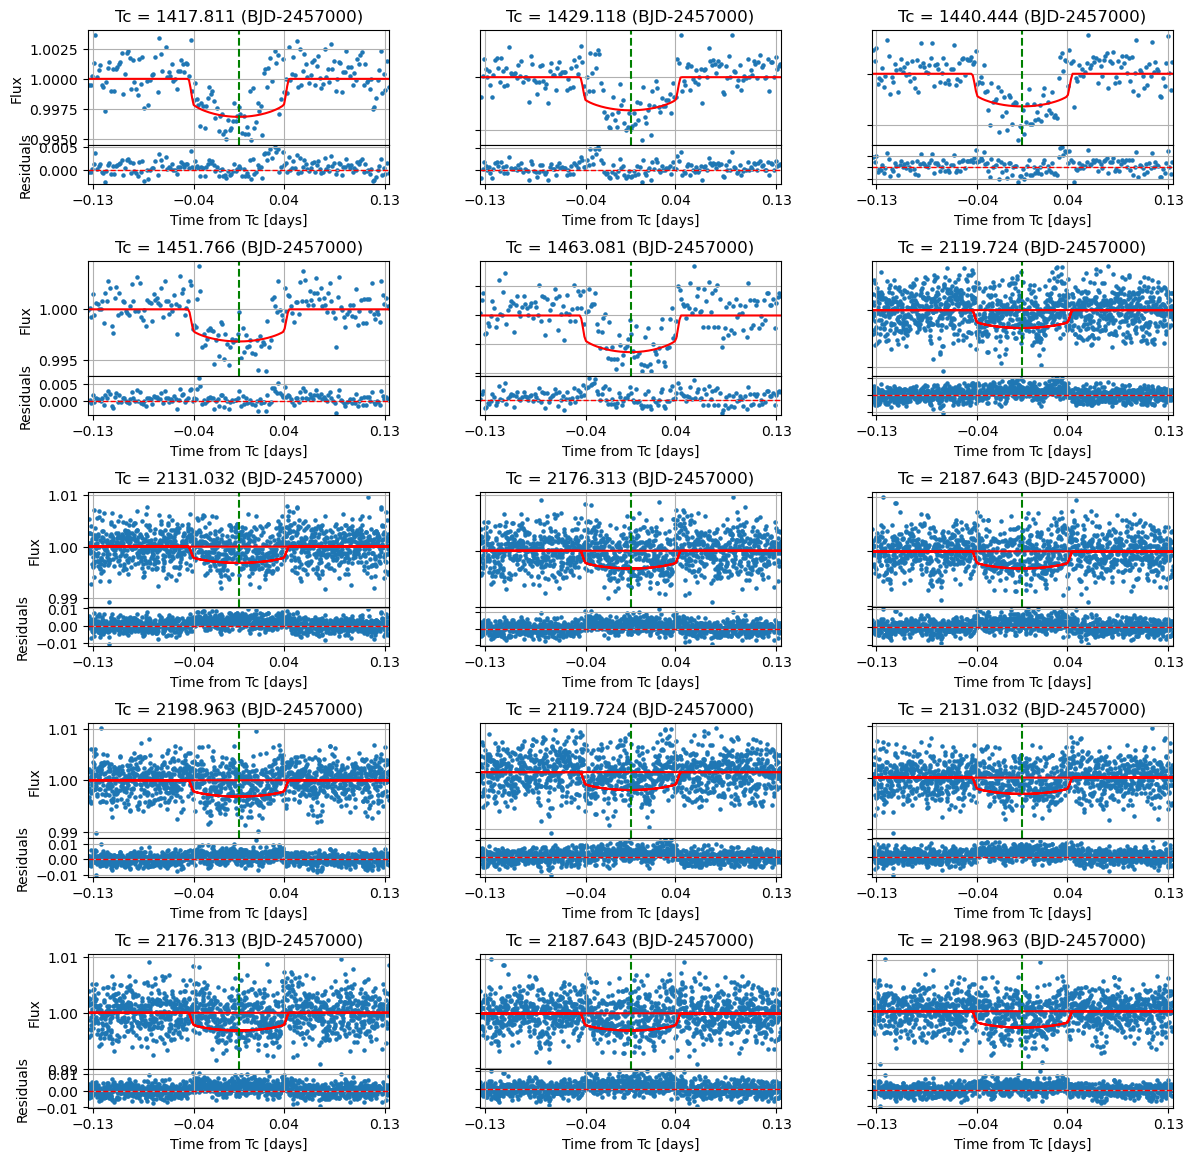

In [49]:
plot_transits(transit_times_1, per_1, rp_1, b_1, T14_1, u1, u2)

## Planet 2

In [50]:
### Planet params (from barros et al 2022)
# planet b
per_2=  5.6605731
rp_2=  0.05701
b_2= 0.28
T14_2= 1.658 * 0.0416667  # convert to days from hours (from Gunther et al 2019)


In [51]:
tc_guess_2 = transit_times_2
### get tc ranges for fit
tc_2 = []
for i in range(len(tc_guess_2)):
    start = tc_guess_2[i] - ttv_hour
    end = tc_guess_2[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_2.append(t)

In [52]:
### initialize arrays
tc_chi = np.zeros(len(tc_2))
tc_chi_parabola = np.zeros(len(tc_2))
ttv = np.zeros(len(tc_2))
ttv_p = np.zeros(len(tc_2))
errors = []
errors_p = []

In [53]:
tc_chi_2, ttv_2 = plot_chi_sq(time, flux, flux_err, tc_2, tc_guess_2, per_2, rp_2, b_2, T14_2, u1, u2)

In [54]:
print(tc_chi_2)

[1389.50159929 1400.82294535 1412.1437274  1434.78265614 1446.10440942
 1457.42598222 2125.37483776 2136.69635486 2181.97964987 2193.30120561
 2125.37496391 2136.69639554 2181.97967386 2193.30121916]


In [55]:
# Transit windows
buffer = 1.5 * T14_2
transit_times_2 = tc_chi_2

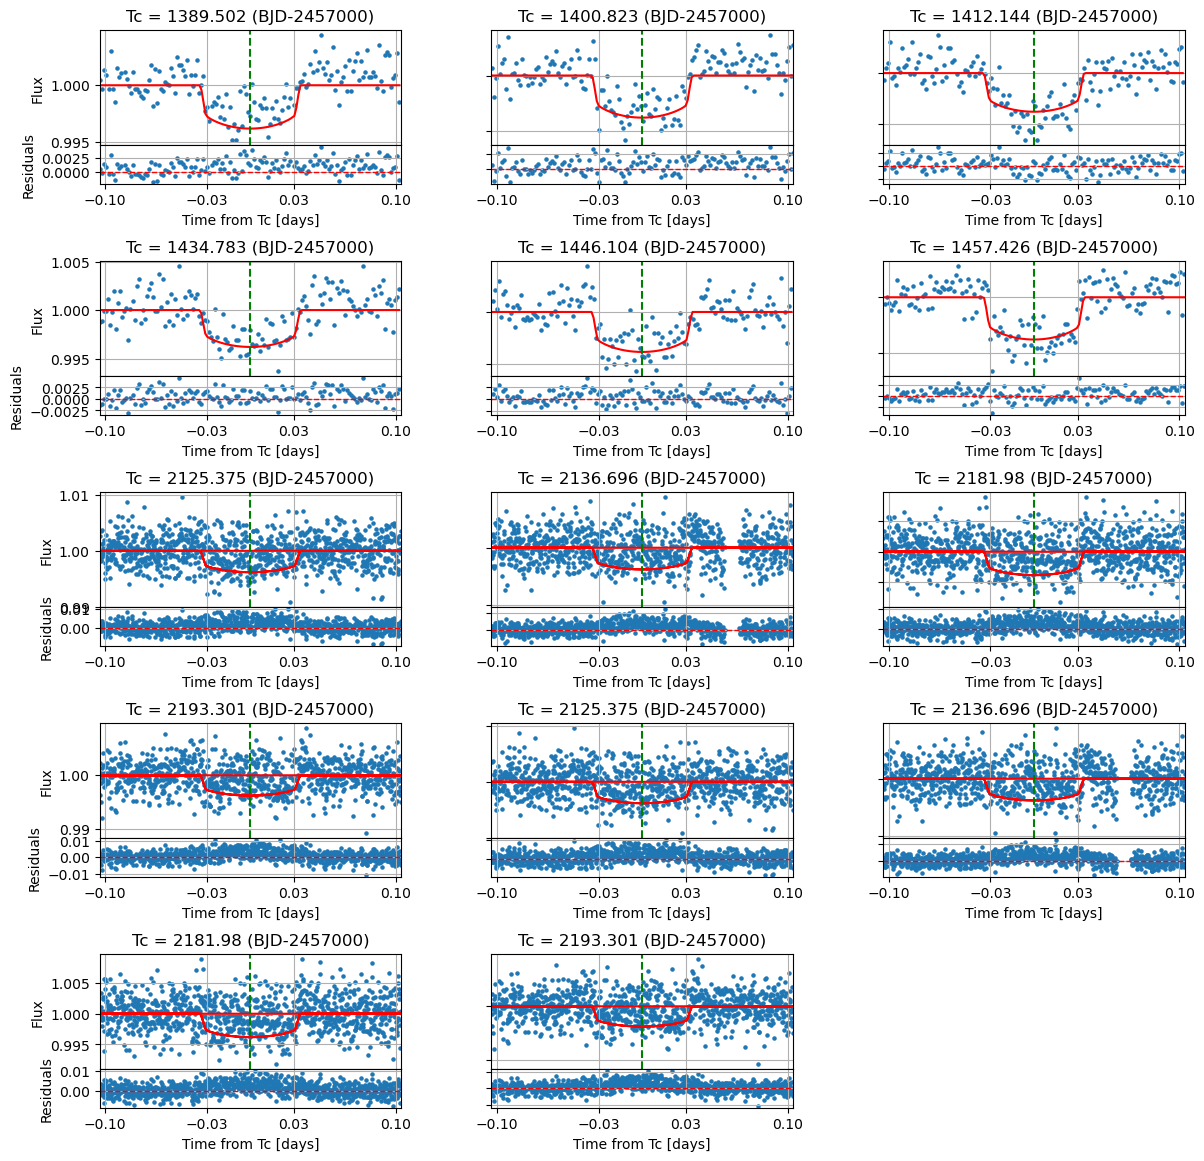

In [56]:
plot_transits(transit_times_2, per_2, rp_2, b_2, T14_2, u1, u2)

In [57]:
### Planet params (from barros et al 2022)
# planet e
per_3= 7.90754
rp_3= 0.01065
b_3= 0.50
T14_3= 2.48 * 0.0416667  # convert to days from hours


In [58]:
tc_guess_3 = transit_times_3
### get tc ranges for fit
tc_3 = []
for i in range(len(tc_guess_3)):
    start = tc_guess_3[i] - 6*ttv_hour
    end = tc_guess_3[i] + 6*ttv_hour
    t = np.linspace(start,end, 1000)
    tc_3.append(t)

In [59]:
### initialize arrays
tc_chi = np.zeros(len(tc_3))
tc_chi_parabola = np.zeros(len(tc_3))
ttv = np.zeros(len(tc_3))
ttv_p = np.zeros(len(tc_3))
errors = []
errors_p = []

In [60]:
plot_chi_sq(time, flux, flux_err, tc_3, tc_guess_3, per_3, rp_3, b_3, T14_3, u1, u2)

(array([1389.68486076, 1393.55405524, 1397.14996947, 1401.05719963,
        1404.82828114, 1412.42886124, 1416.33105621, 1427.70818586,
        1431.35615616, 1435.19763105, 1438.85791588, 1442.79870936,
        1446.57371107, 1454.03059537, 1457.95911956, 1461.83218798,
        2117.98001307, 2121.79416105, 2125.6611184 , 2133.02204105,
        2137.06362047, 2140.73358386, 2174.87092596, 2178.79330521,
        2182.36655257, 2189.95201325, 2193.94420092, 2197.62398893,
        2117.98020387, 2121.79435186, 2125.66053969, 2133.0219253 ,
        2137.06427425, 2140.73323663, 2174.87011578, 2178.79326455,
        2182.36643683, 2189.95143455, 2193.94462323, 2197.62448634]),
 array([ 0.01551553,  0.09159166, -0.10560569,  0.00850852, -0.01351352,
        -0.0005005 ,  0.1086087 ,  0.09959968, -0.03853857,  0.00850852,
        -0.12562573,  0.02352354,  0.00550551, -0.12362372,  0.01051052,
         0.09059066,  0.0005005 ,  0.02152154,  0.09559567, -0.13063074,
         0.11761771, -0.00

In [61]:
# Transit windows
buffer = 1.5 * T14_3
transit_times_3 = tc_chi
print(transit_times_3)

[1389.68486076 1393.55405524 1397.14996947 1401.05719963 1404.82828114
 1412.42886124 1416.33105621 1427.70818586 1431.35615616 1435.19763105
 1438.85791588 1442.79870936 1446.57371107 1454.03059537 1457.95911956
 1461.83218798 2117.98001307 2121.79416105 2125.6611184  2133.02204105
 2137.06362047 2140.73358386 2174.87092596 2178.79330521 2182.36655257
 2189.95201325 2193.94420092 2197.62398893 2117.98020387 2121.79435186
 2125.66053969 2133.0219253  2137.06427425 2140.73323663 2174.87011578
 2178.79326455 2182.36643683 2189.95143455 2193.94462323 2197.62448634]


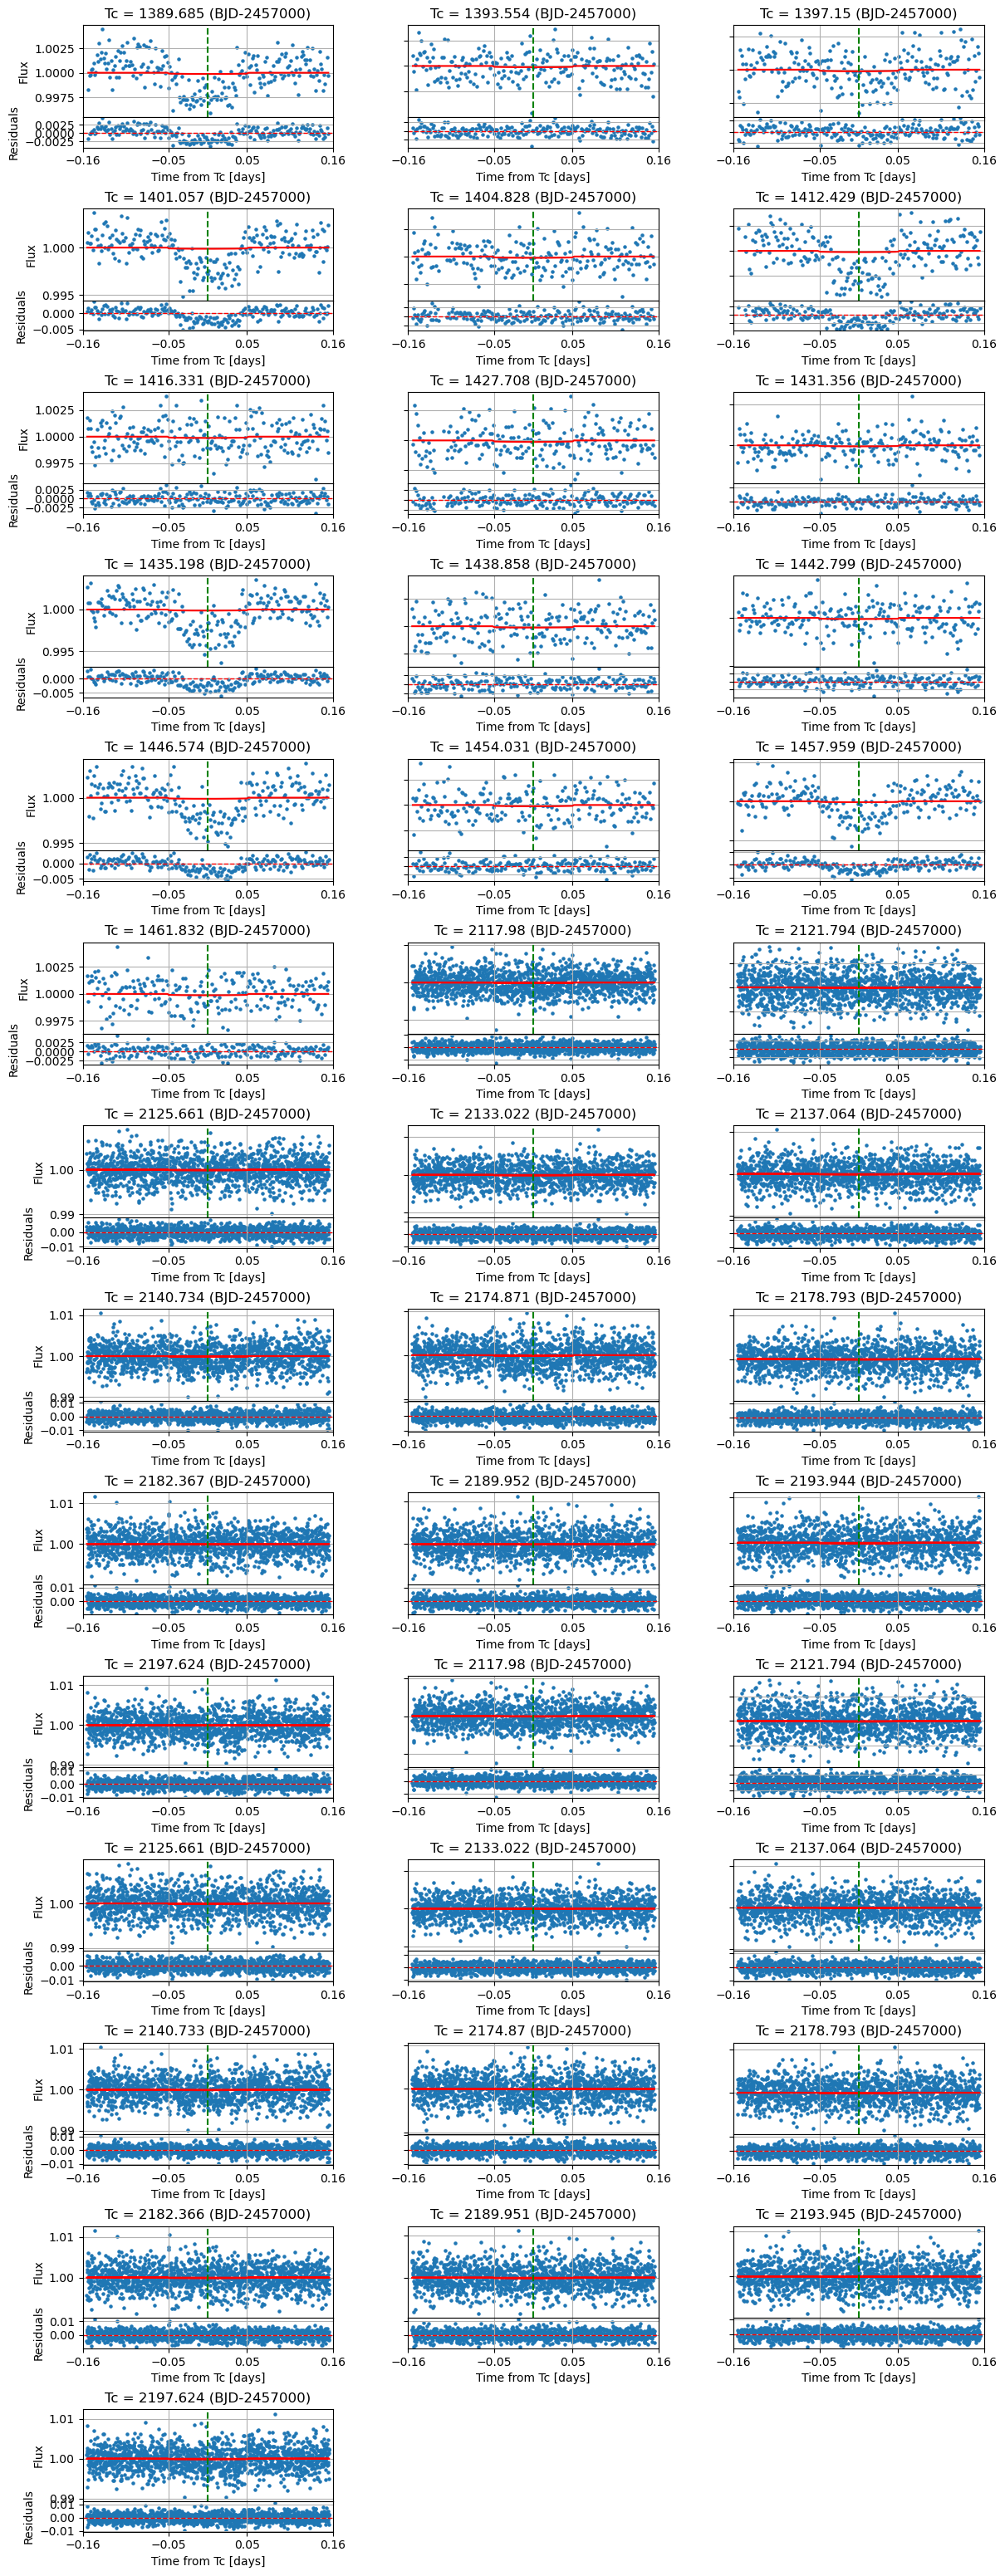

In [62]:
plot_transits(transit_times_3, per_3, rp_3, b_3, T14_3, u1, u2)

In [ ]:
### Planet params (from barros et al 2022)
# planet d
per_4= 3.97664
rp_4= 0.009752
b_4= 0.47
T14_4= 1.99 * 0.0416667  # convert to days from hours


In [ ]:
tc_guess_4 = transit_times_4
### get tc ranges for fit
tc_4 = []
for i in range(len(tc_guess_4)):
    start = tc_guess_4[i] - ttv_hour
    end = tc_guess_4[i] + ttv_hour
    t = np.linspace(start,end, 1000)
    tc_4.append(t)

In [ ]:
### initialize arrays
tc_chi = np.zeros(len(tc_4))
tc_chi_parabola = np.zeros(len(tc_4))
ttv = np.zeros(len(tc_4))
ttv_p = np.zeros(len(tc_4))
errors = []
errors_p = []

In [ ]:
plot_chi_sq(time, flux, flux_err, tc_4, tc_guess_4, per_4, rp_4, b_4, T14_4, u1, u2)

In [ ]:
# Transit windows
buffer = 1.5 * T14_4
transit_times_4 = tc_chi
print(transit_times_4)

In [ ]:
plot_transits(transit_times_4, per_4, rp_4, b_4, T14_4, u1, u2)

# O-C

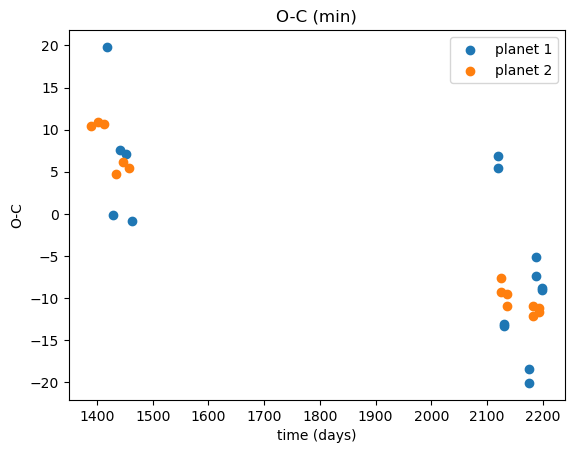

In [64]:
# TTV
plt.scatter(tc_chi_1, ttv_1*(24*60), label='planet 1')
plt.scatter(tc_chi_2, ttv_2*(24*60), label='planet 2')
plt.title('O-C (min)')
plt.xlabel('time (days)')
plt.ylabel('O-C')
plt.legend()
plt.show()

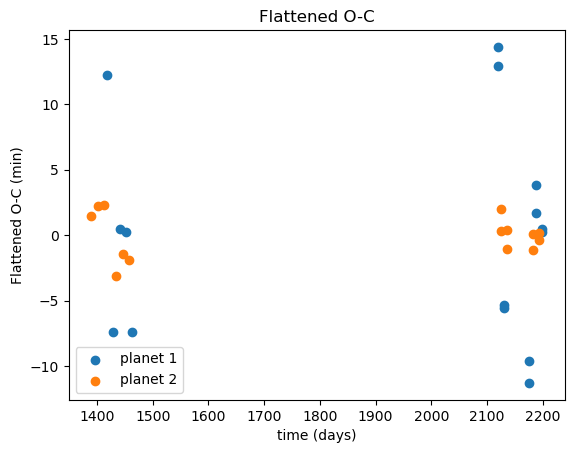

In [77]:
# Fit a linear function to the TTV data
coeffs_1 = np.polyfit(tc_chi_1, ttv_1*(24*60), 1)
linear_fit_1 = np.polyval(coeffs_1, tc_chi_1)

coeffs_2 = np.polyfit(tc_chi_2, ttv_2*(24*60), 1)
linear_fit_2 = np.polyval(coeffs_2, tc_chi_2)

# Subtract the linear fit from the TTV data
ttv_1_detrended = ttv_1*(24*60) - linear_fit_1
ttv_2_detrended = ttv_2*(24*60) - linear_fit_2

# Plot the detrended data
plt.scatter(tc_chi_1, ttv_1_detrended, label='planet 1')
plt.scatter(tc_chi_2, ttv_2_detrended, label='planet 2')
plt.title('Flattened O-C')
plt.xlabel('time (days)')
plt.ylabel('Flattened O-C (min)')
plt.legend()
plt.show()

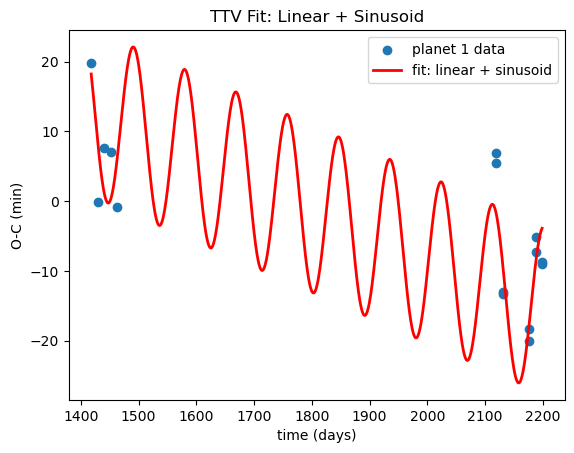


Fit Parameters:
  Slope (a)      = -0.03629 min/day
  Intercept (b)  = 64.23889 min
  Amplitude (A)  = 11.99364 min
  Period (P)     = 88.88 days
  Phase (phi)    = -3.31 rad



In [74]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Convert to minutes
ttv_1_minutes = ttv_1 * 24 * 60

# Sine + linear model
def model(t, a, b, A, P, phi):
    return a * t + b + A * np.sin(2 * np.pi * t / P + phi)

# Initial guesses
# Guess P (period) from visual estimate (e.g., ~100 days), adjust as needed
p0 = [0, np.mean(ttv_1_minutes), 1, 100, 0]  

# Fit the model
params, _ = curve_fit(model, tc_chi_1, ttv_1_minutes, p0=p0, maxfev=10000)

# Extract fit values
a, b, A, P, phi = params

# Generate fitted curve
t_fit = np.linspace(min(tc_chi_1), max(tc_chi_1), 1000)
ttv_fit = model(t_fit, a, b, A, P, phi)

# # Plot data and fit
# plt.scatter(tc_chi_1, ttv_1_minutes, label='planet 1 data')
# plt.plot(t_fit, ttv_fit, color='red', label='fit: linear + sinusoid', linewidth=2)
# plt.title('TTV Fit: Linear + Sinusoid')
# plt.xlabel('time (days)')
# plt.ylabel('O-C (min)')
# plt.legend()
# plt.show()

# # Print parameters
# print(f"""
# Fit Parameters:
#   Slope (a)      = {a:.5f} min/day
#   Intercept (b)  = {b:.5f} min
#   Amplitude (A)  = {A:.5f} min
#   Period (P)     = {P:.2f} days
#   Phase (phi)    = {phi:.2f} rad
# """)


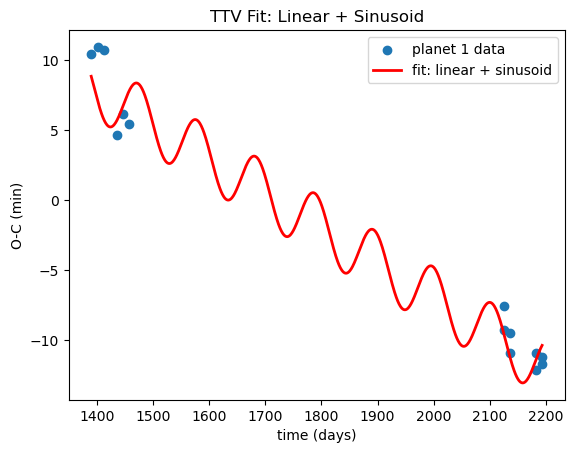


Fit Parameters:
  Slope (a)      = -0.02556 min/day
  Intercept (b)  = 44.45429 min
  Amplitude (A)  = 2.18123 min
  Period (P)     = 102.02 days
  Phase (phi)    = 3.50 rad



In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Convert to minutes
ttv_2_minutes = ttv_2 * 24 * 60

# Sine + linear model
def model(t, a, b, A, P, phi):
    return a * t + b + A * np.sin(2 * np.pi * t / P + phi)

# Initial guesses
# Guess P (period) from visual estimate (e.g., ~100 days), adjust as needed
p0 = [0, np.mean(ttv_2_minutes), 1, 100, 0]  

# Fit the model
params, _ = curve_fit(model, tc_chi_2, ttv_2_minutes, p0=p0, maxfev=10000)

# Extract fit values
a, b, A, P, phi = params

# Generate fitted curve
t_fit_2 = np.linspace(min(tc_chi_2), max(tc_chi_2), 1000)
ttv_fit_2 = model(t_fit, a, b, A, P, phi)

# Plot data and fit
# plt.scatter(tc_chi_2, ttv_2_minutes, label='planet 1 data')
# plt.plot(t_fit_2, ttv_fit_2, color='red', label='fit: linear + sinusoid', linewidth=2)
# plt.title('TTV Fit: Linear + Sinusoid')
# plt.xlabel('time (days)')
# plt.ylabel('O-C (min)')
# plt.legend()
# plt.show()

# Print parameters
# print(f"""
# Fit Parameters:
#   Slope (a)      = {a:.5f} min/day
#   Intercept (b)  = {b:.5f} min
#   Amplitude (A)  = {A:.5f} min
#   Period (P)     = {P:.2f} days
#   Phase (phi)    = {phi:.2f} rad
# """)


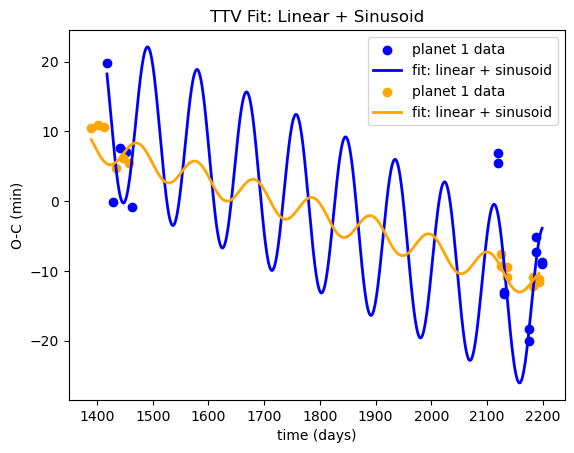

In [76]:
# Plot data and fit
plt.scatter(tc_chi_1, ttv_1_minutes, c='blue',label='planet 1 data')
plt.plot(t_fit, ttv_fit, color='blue', label='fit: linear + sinusoid', linewidth=2)

# Plot data and fit
plt.scatter(tc_chi_2, ttv_2_minutes,c='orange', label='planet 1 data')
plt.plot(t_fit_2, ttv_fit_2, color='orange', label='fit: linear + sinusoid', linewidth=2)
plt.title('TTV Fit: Linear + Sinusoid')
plt.xlabel('time (days)')
plt.ylabel('O-C (min)')
plt.legend()
plt.show()